## alternative arch experiment

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# CIFAR-10 dataset (images and labels)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [7]:
# CNN model (Deep but Narrow)
class DeepButNarrowCNN(nn.Module):
    def __init__(self):
        super(DeepButNarrowCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 32, 3, padding=1)
        self.layer2 = nn.Conv2d(32, 32, 3, padding=1)
        self.layer3 = nn.Conv2d(32, 64, 3, padding=1)
        self.layer4 = nn.Conv2d(64, 64, 3, padding=1)
        self.layer5 = nn.Conv2d(64, 128, 3, padding=1)
        self.layer6 = nn.Conv2d(128, 128, 3, padding=1)
        self.fc = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.layer5(out))
        out = F.relu(self.layer6(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = DeepButNarrowCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch [1/10], Step [100/782], Loss: 1.8975
Epoch [1/10], Step [200/782], Loss: 1.1866
Epoch [1/10], Step [300/782], Loss: 1.5947
Epoch [1/10], Step [400/782], Loss: 1.1908
Epoch [1/10], Step [500/782], Loss: 1.2909
Epoch [1/10], Step [600/782], Loss: 1.4519
Epoch [1/10], Step [700/782], Loss: 1.2809
Epoch [2/10], Step [100/782], Loss: 1.3379
Epoch [2/10], Step [200/782], Loss: 0.9116
Epoch [2/10], Step [300/782], Loss: 0.7973
Epoch [2/10], Step [400/782], Loss: 1.0004
Epoch [2/10], Step [500/782], Loss: 0.9603
Epoch [2/10], Step [600/782], Loss: 0.8637
Epoch [2/10], Step [700/782], Loss: 0.7086
Epoch [3/10], Step [100/782], Loss: 1.0356
Epoch [3/10], Step [200/782], Loss: 0.8289
Epoch [3/10], Step [300/782], Loss: 0.8743
Epoch [3/10], Step [400/782], Loss: 0.8731
Epoch [3/10], Step [500/782], Loss: 0.8518
Epoch [3/10], Step [600/782], Loss: 0.7563
Epoch [3/10], Step [700/782], Loss: 0.5964
Epoch [4/10], Step [100/782], Loss: 0.7970
Epo

In [8]:
class DeepCNNNoPoolingNoStriding(nn.Module):
    def __init__(self):
        super(DeepCNNNoPoolingNoStriding, self).__init__()
        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.layer3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.layer5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.layer6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        # Keeping the spatial dimension same throughout, so 32x32 input results in 32x32 output after conv layers
        self.fc = nn.Linear(128 * 32 * 32, 10)  # Large number of input features to the FC layer

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = F.relu(self.layer5(out))
        out = F.relu(self.layer6(out))
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.fc(out)
        return out

model_no_pooling_no_striding = DeepCNNNoPoolingNoStriding().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_no_pooling_no_striding.parameters(), lr=learning_rate)

# Train the model_no_pooling_no_striding
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_no_pooling_no_striding(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model_no_pooling_no_striding
model_no_pooling_no_striding.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_no_pooling_no_striding(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



Epoch [1/10], Step [100/782], Loss: 1.9773
Epoch [1/10], Step [200/782], Loss: 1.7463
Epoch [1/10], Step [300/782], Loss: 1.8459
Epoch [1/10], Step [400/782], Loss: 1.5274
Epoch [1/10], Step [500/782], Loss: 1.5453
Epoch [1/10], Step [600/782], Loss: 1.5219
Epoch [1/10], Step [700/782], Loss: 1.3501
Epoch [2/10], Step [100/782], Loss: 1.1609
Epoch [2/10], Step [200/782], Loss: 1.2708
Epoch [2/10], Step [300/782], Loss: 1.4547
Epoch [2/10], Step [400/782], Loss: 1.0678
Epoch [2/10], Step [500/782], Loss: 1.1947
Epoch [2/10], Step [600/782], Loss: 1.2415
Epoch [2/10], Step [700/782], Loss: 1.1550
Epoch [3/10], Step [100/782], Loss: 0.9440
Epoch [3/10], Step [200/782], Loss: 1.1037
Epoch [3/10], Step [300/782], Loss: 1.0770
Epoch [3/10], Step [400/782], Loss: 1.1476
Epoch [3/10], Step [500/782], Loss: 1.1093
Epoch [3/10], Step [600/782], Loss: 0.9168
Epoch [3/10], Step [700/782], Loss: 0.8647
Epoch [4/10], Step [100/782], Loss: 0.7568
Epoch [4/10], Step [200/782], Loss: 0.7014
Epoch [4/10

In [12]:
class DeepCNNNoPoolingNoStriding(nn.Module):
    def __init__(self):
        super(DeepCNNNoPoolingNoStriding, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.layer3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.layer5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.layer6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Keeping the spatial dimension same throughout, so 32x32 input results in 32x32 output after conv layers
        self.fc = nn.Linear(64 * 32 * 32, 10)  # Large number of input features to the FC layer

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = F.relu(self.layer5(out))
        out = F.relu(self.layer6(out))
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.fc(out)
        return out

model_no_pooling_no_striding = DeepCNNNoPoolingNoStriding().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_no_pooling_no_striding.parameters(), lr=learning_rate)

# Train the model_no_pooling_no_striding
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_no_pooling_no_striding(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model_no_pooling_no_striding
model_no_pooling_no_striding.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_no_pooling_no_striding(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



Epoch [1/10], Step [100/782], Loss: 2.0367
Epoch [1/10], Step [200/782], Loss: 1.6069
Epoch [1/10], Step [300/782], Loss: 1.4365
Epoch [1/10], Step [400/782], Loss: 1.6237
Epoch [1/10], Step [500/782], Loss: 1.1624
Epoch [1/10], Step [600/782], Loss: 1.4353
Epoch [1/10], Step [700/782], Loss: 1.2655
Epoch [2/10], Step [100/782], Loss: 1.2112
Epoch [2/10], Step [200/782], Loss: 0.9067
Epoch [2/10], Step [300/782], Loss: 1.0452
Epoch [2/10], Step [400/782], Loss: 1.0410
Epoch [2/10], Step [500/782], Loss: 1.0729
Epoch [2/10], Step [600/782], Loss: 0.9605
Epoch [2/10], Step [700/782], Loss: 1.0249
Epoch [3/10], Step [100/782], Loss: 0.9521
Epoch [3/10], Step [200/782], Loss: 0.6517
Epoch [3/10], Step [300/782], Loss: 0.9917
Epoch [3/10], Step [400/782], Loss: 0.8162
Epoch [3/10], Step [500/782], Loss: 0.9734
Epoch [3/10], Step [600/782], Loss: 0.7849
Epoch [3/10], Step [700/782], Loss: 0.7072
Epoch [4/10], Step [100/782], Loss: 0.9017
Epoch [4/10], Step [200/782], Loss: 0.6867
Epoch [4/10

In [4]:
class DeepButNarrowCNNNoPooling(nn.Module):
    def __init__(self):
        super(DeepButNarrowCNNNoPooling, self).__init__()
        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.layer2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)  # Strided convolution for downsampling
        self.layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.layer4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)  # Strided convolution for downsampling
        self.layer5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.layer6 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # Strided convolution for downsampling
        self.fc = nn.Linear(128 * 4 * 4, 10)  # Adjusted for the downsampling

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = F.relu(self.layer5(out))
        out = F.relu(self.layer6(out))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model_no_pooling = DeepButNarrowCNNNoPooling().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_no_pooling.parameters(), lr=learning_rate)

# Train the model_no_pooling
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_no_pooling(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model_no_pooling
model_no_pooling.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_no_pooling(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



Files already downloaded and verified
Epoch [1/10], Step [100/782], Loss: 1.8552
Epoch [1/10], Step [200/782], Loss: 1.6673
Epoch [1/10], Step [300/782], Loss: 1.6695
Epoch [1/10], Step [400/782], Loss: 1.5474
Epoch [1/10], Step [500/782], Loss: 1.5634
Epoch [1/10], Step [600/782], Loss: 1.3211
Epoch [1/10], Step [700/782], Loss: 1.3915
Epoch [2/10], Step [100/782], Loss: 1.0290
Epoch [2/10], Step [200/782], Loss: 1.3137
Epoch [2/10], Step [300/782], Loss: 1.1727
Epoch [2/10], Step [400/782], Loss: 1.1137
Epoch [2/10], Step [500/782], Loss: 0.9542
Epoch [2/10], Step [600/782], Loss: 1.1167
Epoch [2/10], Step [700/782], Loss: 0.9335
Epoch [3/10], Step [100/782], Loss: 0.8416
Epoch [3/10], Step [200/782], Loss: 0.9012
Epoch [3/10], Step [300/782], Loss: 0.9940
Epoch [3/10], Step [400/782], Loss: 1.1360
Epoch [3/10], Step [500/782], Loss: 0.8969
Epoch [3/10], Step [600/782], Loss: 0.6574
Epoch [3/10], Step [700/782], Loss: 1.0711
Epoch [4/10], Step [100/782], Loss: 0.7665
Epoch [4/10], St

In [5]:
class DeepCNNWithAvgPooling(nn.Module):
    def __init__(self):
        super(DeepCNNWithAvgPooling, self).__init__()
        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.avgpool1 = nn.AvgPool2d(2, stride=2)
        self.layer3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.avgpool2 = nn.AvgPool2d(2, stride=2)
        self.layer5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.layer6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.avgpool3 = nn.AvgPool2d(2, stride=2)
        self.fc = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.avgpool1(out)
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = self.avgpool2(out)
        out = F.relu(self.layer5(out))
        out = F.relu(self.layer6(out))
        out = self.avgpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model_with_avg_pooling = DeepCNNWithAvgPooling().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_avg_pooling.parameters(), lr=learning_rate)

# Train the model_with_avg_pooling
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_with_avg_pooling(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model_with_avg_pooling
model_with_avg_pooling.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_with_avg_pooling(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



Epoch [1/10], Step [100/782], Loss: 1.8212
Epoch [1/10], Step [200/782], Loss: 1.5978
Epoch [1/10], Step [300/782], Loss: 1.6023
Epoch [1/10], Step [400/782], Loss: 1.3932
Epoch [1/10], Step [500/782], Loss: 1.4105
Epoch [1/10], Step [600/782], Loss: 1.4241
Epoch [1/10], Step [700/782], Loss: 1.3741
Epoch [2/10], Step [100/782], Loss: 1.1217
Epoch [2/10], Step [200/782], Loss: 1.1096
Epoch [2/10], Step [300/782], Loss: 1.0970
Epoch [2/10], Step [400/782], Loss: 1.1788
Epoch [2/10], Step [500/782], Loss: 1.0956
Epoch [2/10], Step [600/782], Loss: 0.9277
Epoch [2/10], Step [700/782], Loss: 1.0410
Epoch [3/10], Step [100/782], Loss: 1.0196
Epoch [3/10], Step [200/782], Loss: 1.1829
Epoch [3/10], Step [300/782], Loss: 1.0102
Epoch [3/10], Step [400/782], Loss: 1.0232
Epoch [3/10], Step [500/782], Loss: 0.8163
Epoch [3/10], Step [600/782], Loss: 0.9078
Epoch [3/10], Step [700/782], Loss: 0.7252
Epoch [4/10], Step [100/782], Loss: 0.7129
Epoch [4/10], Step [200/782], Loss: 0.7875
Epoch [4/10

In [11]:
class DeepCNNWithAvgPoolingConstantChannels(nn.Module):
    def __init__(self):
        super(DeepCNNWithAvgPoolingConstantChannels, self).__init__()
        self.layer1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.avgpool1 = nn.AvgPool2d(2, stride=2)
        self.layer3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.avgpool2 = nn.AvgPool2d(2, stride=2)
        self.layer5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.layer6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.avgpool3 = nn.AvgPool2d(2, stride=2)
        self.fc = nn.Linear(256 * 4 * 4, 10)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.avgpool1(out)
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = self.avgpool2(out)
        out = F.relu(self.layer5(out))
        out = F.relu(self.layer6(out))
        out = self.avgpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model_with_avg_pooling_constant_channels = DeepCNNWithAvgPoolingConstantChannels().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_avg_pooling_constant_channels.parameters(), lr=learning_rate)

# Train the model_with_avg_pooling_constant_channels
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_with_avg_pooling_constant_channels(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model_with_avg_pooling_constant_channels
model_with_avg_pooling_constant_channels.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_with_avg_pooling_constant_channels(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



Epoch [1/10], Step [100/782], Loss: 1.7938
Epoch [1/10], Step [200/782], Loss: 1.7104
Epoch [1/10], Step [300/782], Loss: 1.4952
Epoch [1/10], Step [400/782], Loss: 1.3783
Epoch [1/10], Step [500/782], Loss: 1.2984
Epoch [1/10], Step [600/782], Loss: 1.3925
Epoch [1/10], Step [700/782], Loss: 1.5976
Epoch [2/10], Step [100/782], Loss: 1.1288
Epoch [2/10], Step [200/782], Loss: 1.0793
Epoch [2/10], Step [300/782], Loss: 1.0554
Epoch [2/10], Step [400/782], Loss: 1.0934
Epoch [2/10], Step [500/782], Loss: 0.7481
Epoch [2/10], Step [600/782], Loss: 0.8244
Epoch [2/10], Step [700/782], Loss: 0.8229
Epoch [3/10], Step [100/782], Loss: 0.6758
Epoch [3/10], Step [200/782], Loss: 0.9416
Epoch [3/10], Step [300/782], Loss: 0.5464
Epoch [3/10], Step [400/782], Loss: 0.6421
Epoch [3/10], Step [500/782], Loss: 0.7798
Epoch [3/10], Step [600/782], Loss: 0.7156
Epoch [3/10], Step [700/782], Loss: 0.7198
Epoch [4/10], Step [100/782], Loss: 0.5683
Epoch [4/10], Step [200/782], Loss: 0.5603
Epoch [4/10

In [7]:
class DeepCNNWithAvgPoolingConstantChannels(nn.Module):
    def __init__(self):
        super(DeepCNNWithAvgPoolingConstantChannels, self).__init__()
        self.layer1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.avgpool1 = nn.AvgPool2d(2, stride=2)
        self.layer3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.avgpool2 = nn.AvgPool2d(2, stride=2)
        self.layer5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.layer6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.avgpool3 = nn.AvgPool2d(2, stride=2)
        self.fc = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.avgpool1(out)
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = self.avgpool2(out)
        out = F.relu(self.layer5(out))
        out = F.relu(self.layer6(out))
        out = self.avgpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model_with_avg_pooling_constant_channels = DeepCNNWithAvgPoolingConstantChannels().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_avg_pooling_constant_channels.parameters(), lr=learning_rate)

# Train the model_with_avg_pooling_constant_channels
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_with_avg_pooling_constant_channels(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model_with_avg_pooling_constant_channels
model_with_avg_pooling_constant_channels.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_with_avg_pooling_constant_channels(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



Epoch [1/10], Step [100/782], Loss: 1.8975
Epoch [1/10], Step [200/782], Loss: 1.7205
Epoch [1/10], Step [300/782], Loss: 1.6065
Epoch [1/10], Step [400/782], Loss: 1.3666
Epoch [1/10], Step [500/782], Loss: 1.3453
Epoch [1/10], Step [600/782], Loss: 1.4118
Epoch [1/10], Step [700/782], Loss: 1.2491
Epoch [2/10], Step [100/782], Loss: 1.0472
Epoch [2/10], Step [200/782], Loss: 1.1361
Epoch [2/10], Step [300/782], Loss: 1.0448
Epoch [2/10], Step [400/782], Loss: 1.0611
Epoch [2/10], Step [500/782], Loss: 0.7402
Epoch [2/10], Step [600/782], Loss: 0.7919
Epoch [2/10], Step [700/782], Loss: 0.9403
Epoch [3/10], Step [100/782], Loss: 0.7273
Epoch [3/10], Step [200/782], Loss: 0.7532
Epoch [3/10], Step [300/782], Loss: 0.6992
Epoch [3/10], Step [400/782], Loss: 0.7046
Epoch [3/10], Step [500/782], Loss: 0.6826
Epoch [3/10], Step [600/782], Loss: 0.6004
Epoch [3/10], Step [700/782], Loss: 0.7906
Epoch [4/10], Step [100/782], Loss: 0.6320
Epoch [4/10], Step [200/782], Loss: 0.8736
Epoch [4/10

In [8]:
class DeepCNNWithAvgPoolingConstantChannels(nn.Module):
    def __init__(self):
        super(DeepCNNWithAvgPoolingConstantChannels, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.avgpool1 = nn.AvgPool2d(2, stride=2)
        self.layer3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.avgpool2 = nn.AvgPool2d(2, stride=2)
        self.layer5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.layer6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.avgpool3 = nn.AvgPool2d(2, stride=2)
        self.fc = nn.Linear(64 * 4 * 4, 10)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.avgpool1(out)
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = self.avgpool2(out)
        out = F.relu(self.layer5(out))
        out = F.relu(self.layer6(out))
        out = self.avgpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model_with_avg_pooling_constant_channels = DeepCNNWithAvgPoolingConstantChannels().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_avg_pooling_constant_channels.parameters(), lr=learning_rate)

# Train the model_with_avg_pooling_constant_channels
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_with_avg_pooling_constant_channels(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model_with_avg_pooling_constant_channels
model_with_avg_pooling_constant_channels.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_with_avg_pooling_constant_channels(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



Epoch [1/10], Step [100/782], Loss: 1.5930
Epoch [1/10], Step [200/782], Loss: 1.5423
Epoch [1/10], Step [300/782], Loss: 1.4887
Epoch [1/10], Step [400/782], Loss: 1.3591
Epoch [1/10], Step [500/782], Loss: 1.2652
Epoch [1/10], Step [600/782], Loss: 1.3295
Epoch [1/10], Step [700/782], Loss: 1.1923
Epoch [2/10], Step [100/782], Loss: 1.2057
Epoch [2/10], Step [200/782], Loss: 1.2615
Epoch [2/10], Step [300/782], Loss: 1.1962
Epoch [2/10], Step [400/782], Loss: 0.9189
Epoch [2/10], Step [500/782], Loss: 1.0666
Epoch [2/10], Step [600/782], Loss: 0.9643
Epoch [2/10], Step [700/782], Loss: 1.1659
Epoch [3/10], Step [100/782], Loss: 0.9411
Epoch [3/10], Step [200/782], Loss: 0.8487
Epoch [3/10], Step [300/782], Loss: 1.0320
Epoch [3/10], Step [400/782], Loss: 0.8592
Epoch [3/10], Step [500/782], Loss: 0.8117
Epoch [3/10], Step [600/782], Loss: 0.8880
Epoch [3/10], Step [700/782], Loss: 0.9210
Epoch [4/10], Step [100/782], Loss: 0.6578
Epoch [4/10], Step [200/782], Loss: 1.0378
Epoch [4/10

In [9]:
class DeepCNNWithAvgPoolingConstantChannels(nn.Module):
    def __init__(self):
        super(DeepCNNWithAvgPoolingConstantChannels, self).__init__()
        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.avgpool1 = nn.AvgPool2d(2, stride=2)
        self.layer3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.avgpool2 = nn.AvgPool2d(2, stride=2)
        self.layer5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.layer6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.avgpool3 = nn.AvgPool2d(2, stride=2)
        self.fc = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.avgpool1(out)
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = self.avgpool2(out)
        out = F.relu(self.layer5(out))
        out = F.relu(self.layer6(out))
        out = self.avgpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model_with_avg_pooling_constant_channels = DeepCNNWithAvgPoolingConstantChannels().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_avg_pooling_constant_channels.parameters(), lr=learning_rate)

# Train the model_with_avg_pooling_constant_channels
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_with_avg_pooling_constant_channels(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model_with_avg_pooling_constant_channels
model_with_avg_pooling_constant_channels.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_with_avg_pooling_constant_channels(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



Epoch [1/10], Step [100/782], Loss: 2.1611
Epoch [1/10], Step [200/782], Loss: 1.7804
Epoch [1/10], Step [300/782], Loss: 1.5337
Epoch [1/10], Step [400/782], Loss: 1.4270
Epoch [1/10], Step [500/782], Loss: 1.7451
Epoch [1/10], Step [600/782], Loss: 1.5150
Epoch [1/10], Step [700/782], Loss: 1.1501
Epoch [2/10], Step [100/782], Loss: 1.5442
Epoch [2/10], Step [200/782], Loss: 1.3839
Epoch [2/10], Step [300/782], Loss: 1.3410
Epoch [2/10], Step [400/782], Loss: 1.3856
Epoch [2/10], Step [500/782], Loss: 1.2276
Epoch [2/10], Step [600/782], Loss: 1.4093
Epoch [2/10], Step [700/782], Loss: 1.2505
Epoch [3/10], Step [100/782], Loss: 1.1723
Epoch [3/10], Step [200/782], Loss: 1.0134
Epoch [3/10], Step [300/782], Loss: 1.3111
Epoch [3/10], Step [400/782], Loss: 0.8358
Epoch [3/10], Step [500/782], Loss: 1.3744
Epoch [3/10], Step [600/782], Loss: 0.9760
Epoch [3/10], Step [700/782], Loss: 0.9385
Epoch [4/10], Step [100/782], Loss: 1.0020
Epoch [4/10], Step [200/782], Loss: 0.8384
Epoch [4/10

In [10]:
class DeepCNNWithAvgPoolingConstantChannels(nn.Module):
    def __init__(self):
        super(DeepCNNWithAvgPoolingConstantChannels, self).__init__()
        self.layer1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.avgpool1 = nn.AvgPool2d(2, stride=2)
        self.layer3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.avgpool2 = nn.AvgPool2d(2, stride=2)
        self.layer5 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.layer6 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.avgpool3 = nn.AvgPool2d(2, stride=2)
        self.fc = nn.Linear(16 * 4 * 4, 10)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.avgpool1(out)
        out = F.relu(self.layer3(out))
        out = F.relu(self.layer4(out))
        out = self.avgpool2(out)
        out = F.relu(self.layer5(out))
        out = F.relu(self.layer6(out))
        out = self.avgpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model_with_avg_pooling_constant_channels = DeepCNNWithAvgPoolingConstantChannels().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_avg_pooling_constant_channels.parameters(), lr=learning_rate)

# Train the model_with_avg_pooling_constant_channels
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_with_avg_pooling_constant_channels(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model_with_avg_pooling_constant_channels
model_with_avg_pooling_constant_channels.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_with_avg_pooling_constant_channels(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



Epoch [1/10], Step [100/782], Loss: 2.1601
Epoch [1/10], Step [200/782], Loss: 1.7929
Epoch [1/10], Step [300/782], Loss: 1.8409
Epoch [1/10], Step [400/782], Loss: 1.5978
Epoch [1/10], Step [500/782], Loss: 1.7161
Epoch [1/10], Step [600/782], Loss: 1.5679
Epoch [1/10], Step [700/782], Loss: 1.5398
Epoch [2/10], Step [100/782], Loss: 1.5118
Epoch [2/10], Step [200/782], Loss: 1.4132
Epoch [2/10], Step [300/782], Loss: 1.5023
Epoch [2/10], Step [400/782], Loss: 1.4884
Epoch [2/10], Step [500/782], Loss: 1.3626
Epoch [2/10], Step [600/782], Loss: 1.6282
Epoch [2/10], Step [700/782], Loss: 1.4192
Epoch [3/10], Step [100/782], Loss: 1.4644
Epoch [3/10], Step [200/782], Loss: 1.4361
Epoch [3/10], Step [300/782], Loss: 1.5522
Epoch [3/10], Step [400/782], Loss: 1.3692
Epoch [3/10], Step [500/782], Loss: 1.2385
Epoch [3/10], Step [600/782], Loss: 1.3618
Epoch [3/10], Step [700/782], Loss: 1.6945
Epoch [4/10], Step [100/782], Loss: 1.3187
Epoch [4/10], Step [200/782], Loss: 1.2664
Epoch [4/10

# Setup and utils

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import json, copy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from types import SimpleNamespace
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata
import math
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------ MODEL UTILS ----------------------------------------------

def generate_cnn(params, output_dim):
    model = CustomCNN(output_dim, params['depth'], params['width'], params['activation_function'], params['kernel_size'], params['use_pooling'])
    return model

class Trainer:
    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """
    def __init__(self, model, dataloader, lr, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params
        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        # optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0
        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)

    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):
          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])
          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self, verbose=1):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            if verbose >= 1:
                self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
                self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):
    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

def cut_custom_cnn_model(model, cut_point, params, output_dim):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original CustomCNN model.
    - cut_point (int): Layer index (in terms of conv layers) at which to modify the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.
    - reinitialize (bool): If True, layers after cut_point will have their weights reinitialized.

    Returns:
    - new_model (CustomCNN): Modified model.
    """

    new_model = copy.deepcopy(model)

    # Get names of layers in the model
    layer_names = list(new_model._modules.keys())

    # Find indices of Conv layers
    conv_indices = [i for i, name in enumerate(layer_names) if 'conv' in name]
    #print(conv_indices)

    # If freeze is True, set requires_grad to False for layers before cut_point
    if params["freeze"]:
        for idx in conv_indices[:cut_point]:
            for param in getattr(new_model, layer_names[idx]).parameters():
                param.requires_grad = False

    # Reinitialize layers after cut_point
    if params["reinit"]:
        for idx in conv_indices[cut_point:]:
            layer = getattr(new_model, layer_names[idx])
            layer.reset_parameters()
            """
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
            """

    """# if reinit_both_dense: reinit the one before the last one too
    if params["reinit_both_dense"]:
        new_model.fc_1.reset_parameters()"""

    # reinit the final dense layer anyway
    # new_model.fc.reset_parameters()

    new_model.fc = nn.Linear(new_model._to_linear, output_dim)
    
    return new_model

# --------------------------------- DATA UTILS -----------------------------------
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

"""class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)"""

class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, selected_classes):
        self.dataset = dataset
        self.label_encoder = LabelEncoder()
        
        # Fit label encoder on the selected classes
        self.label_encoder.fit(selected_classes)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        
        # Transform the label using the fitted label encoder
        label = self.label_encoder.transform([label])[0]
        
        return data, label

    def __len__(self):
        return len(self.dataset)

class TransferLearningFashionMNIST(object):
    """
    Prepares the FashionMNIST dataset for transfer learning, dividing it into pretraining and fine-tuning datasets.

    Parameters:
    - batch_size (int): Batch size for data loaders.
    - input_dim (int): The dimensionality of the input data.
    - val_split (float): The proportion of validation data.
    - num_workers (int): Number of workers for data loaders.
    - seed (int): Seed for random operations.
    """
    def __init__(self, batch_size, params):
        self.pre_train_classes = params["pre_train_classes"]
        self.fine_tune_classes = params['fine_tune_classes']

        # we also relabel the samples for both the pretrain and the fine-tune datasets, 
        # to make sure everything is correct [0,N] -usign sklearn OrdinalEncoder to be more robust
        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return RelabeledSubset(torch.utils.data.Subset(dataset, indices), classes)

        fashion_train_data = datasets.FashionMNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(fashion_train_data, params['pre_train_classes'])
        finetune_train_data = filter_dataset(fashion_train_data, params['fine_tune_classes'])

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(params['val_split'] * pretrain_len)
        finetune_val_len = int(params['val_split'] * finetune_len)
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(params['generate_dataset_seed']))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(params['generate_dataset_seed']))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=params['num_workers'])
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        """# Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)"""

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=params['num_workers'])
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        fashion_test_data = datasets.FashionMNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(fashion_test_data, params['pre_train_classes'])
        finetune_test_data = filter_dataset(fashion_test_data, params['fine_tune_classes'])

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(fashion_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

class TransferLearningWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningObj, phase):
        """
        Initializes the TransferLearningrapper object.

        Parameters:
        - transferLearningObj: An instance of the TransferLearningMNIST or TransferLearningFashionMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningObj = transferLearningObj
        # self.phase = phase
        # self.input_dim = self.transferLearningMNISTObj.input_dim
        # self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningObj.pretrain_train_loader
            self.val_loader = self.transferLearningObj.pretrain_val_loader
            self.test_loader = self.transferLearningObj.pretrain_test_loader
            self.output_dim = len(self.transferLearningObj.pre_train_classes)
        elif phase == 'finetune':
            self.train_loader = self.transferLearningObj.finetune_train_loader
            self.val_loader = self.transferLearningObj.finetune_val_loader
            self.test_loader = self.transferLearningObj.finetune_test_loader
            self.output_dim = len(self.transferLearningObj.fine_tune_classes)
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase
    
def check_class_distribution(loader, expected_classes, loader_name):
    class_counts = {label: 0 for label in expected_classes}
    for _, labels in loader:
        for label in labels:
            if label.item() in class_counts:
                class_counts[label.item()] += 1
            else:
                print(f"Unexpected class {label.item()} found in {loader_name}")
    print(f"Class distribution in {loader_name}: {class_counts}")

def test_data_loaders(tl_fashion_mnist, params):
    # Test and check data loaders
    for loader_name, loader in [
        ("Pretrain Train", tl_fashion_mnist.pretrain_train_loader),
        ("Pretrain Val", tl_fashion_mnist.pretrain_val_loader),
        ("Pretrain Test", tl_fashion_mnist.pretrain_test_loader),
        ("Finetune Train", tl_fashion_mnist.finetune_train_loader),
        ("Finetune Val", tl_fashion_mnist.finetune_val_loader),
        ("Finetune Test", tl_fashion_mnist.finetune_test_loader)
    ]:
        check_class_distribution(
            loader, 
            tl_fashion_mnist.pre_train_classes if "Pretrain" in loader_name else tl_fashion_mnist.fine_tune_classes, 
            loader_name
        )
# ------------------------------------------ PLOTTING UTILS -------------------------------------------
'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

In [2]:
import torch
from torchvision import datasets, transforms
import math

class CustomCNN(nn.Module):
    def __init__(self, output_dim, depth, num_channels, activation_function, kernel_size, use_pooling=True):
        super(CustomCNN, self).__init__()

        # Change initial number of input channels for RGB images
        in_channels = 3

        for i in range(depth):
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=math.floor(kernel_size/2)))
            setattr(self, f"act{i}", activation_function())

            if use_pooling and (i+1) % depth == 0:
                setattr(self, f"pool{i}", nn.AvgPool2d(2, 2))

            in_channels = num_channels

        self.calculate_to_linear_size()

        self.fc = nn.Linear(self._to_linear, output_dim)

    def calculate_to_linear_size(self):
        # Adjust the dummy input tensor for CIFAR-10
        x = torch.zeros(1, 3, 32, 32)
        for layer_name, layer in self.named_children():
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            elif "pool" in layer_name:
                x = layer(x)
            elif isinstance(layer, nn.Linear):
                break
        self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        for layer_name, layer in self.named_children():
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            elif "pool" in layer_name:
                x = layer(x)
            elif isinstance(layer, nn.Linear):
                break

        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    

class TransferLearningCIFAR10:
    def __init__(self, batch_size, params):
        self.pre_train_classes = params["pre_train_classes"]
        self.fine_tune_classes = params["fine_tune_classes"]

        # Function to filter dataset
        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return RelabeledSubset(torch.utils.data.Subset(dataset, indices), classes)

        # Load CIFAR-10 dataset
        cifar_train_data = datasets.CIFAR10(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]))

        pretrain_train_data = filter_dataset(cifar_train_data, params['pre_train_classes'])
        finetune_train_data = filter_dataset(cifar_train_data, params['fine_tune_classes'])

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(params['val_split'] * pretrain_len)
        finetune_val_len = int(params['val_split'] * finetune_len)

        # Split the datasets
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(params['generate_dataset_seed']))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(params['generate_dataset_seed']))

        # Create data loaders
        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=params['num_workers'])
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=params['num_workers'])
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        cifar_test_data = datasets.CIFAR10(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]))

        pretrain_test_data = filter_dataset(cifar_test_data, params['pre_train_classes'])
        finetune_test_data = filter_dataset(cifar_test_data, params['fine_tune_classes'])

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        # Complete test loader for CIFAR-10
        self.complete_test_loader = torch.utils.data.DataLoader(cifar_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

# The TransferLearningWrapper class remains the same.

# Helper function to check class distribution in loaders
def check_class_distribution(loader, expected_classes, loader_name):
    class_counts = {label: 0 for label in expected_classes}
    for _, labels in loader:
        for label in labels:
            if label.item() in class_counts:
                class_counts[label.item()] += 1
            else:
                print(f"Unexpected class {label.item()} found in {loader_name}")
    print(f"Class distribution in {loader_name}: {class_counts}")


class Trainer:
    def __init__(self, model, dataloader, lr, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params
        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0
        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)

    def train_epoch(self):
        self.model.train()
        for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = F.cross_entropy(output, target) # Changed to cross_entropy for CIFAR-10
            loss.backward()
            self.optimizer.step()

            if self.is_debug and batch_idx % 20 == 0:
                self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self, verbose=1):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            if verbose >= 1:
                self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
                self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints
    

def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):
    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # Changed to cross_entropy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

# EXPERIMENT SETUP 1: _FREEZE, REINIT, POOLING, DENSE:REINIT BOTH


In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
#percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1]

# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3,4,5, 6]
#seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # currently not being used
batch_size = 4096

## Pretraining



In [6]:
# Changes Here for the experiments
params = {
      # MODEL ARCHITECTURE PARAMS
      'depth': 6,
      'width': 64, # num channels for CNN
      # 'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 3,
      # TRAINING PARAMS
      'device': device,
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.001,  # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 10,
      'early_stop_patience': 5,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'batch_size':batch_size,
      # DATASET PARAMS
      'pre_train_classes': [2, 3, 4, 5, 6, 7],
      'fine_tune_classes': [0, 1, 8, 9],
        'val_split': 0.1,
      'num_workers': 0,
      'generate_dataset_seed': 42,
      # EXPERIMENT SETTING PARAMS
      'percentages':percentages,
      'use_pooling': False,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': True,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

In [7]:
dataloader = TransferLearningCIFAR10(batch_size, params)
dataloader_wrapped = TransferLearningWrapper(dataloader, phase = 'pretrain')

Files already downloaded and verified
Files already downloaded and verified


Epoch: 0 	Training Accuracy: 27.46%
Validation Accuracy: 28.16%
Epoch: 1 	Training Accuracy: 32.28%
Validation Accuracy: 32.72%
Epoch: 2 	Training Accuracy: 36.84%
Validation Accuracy: 36.62%
Epoch: 3 	Training Accuracy: 41.02%
Validation Accuracy: 40.68%
Epoch: 4 	Training Accuracy: 43.50%
Validation Accuracy: 43.48%
Epoch: 5 	Training Accuracy: 45.49%
Validation Accuracy: 44.32%
Epoch: 6 	Training Accuracy: 46.70%
Validation Accuracy: 45.58%
Epoch: 7 	Training Accuracy: 47.92%
Validation Accuracy: 47.00%
Epoch: 8 	Training Accuracy: 48.99%
Validation Accuracy: 47.52%
Epoch: 9 	Training Accuracy: 50.22%
Validation Accuracy: 48.96%
Epoch: 10 	Training Accuracy: 51.48%
Validation Accuracy: 49.86%
Epoch: 11 	Training Accuracy: 52.98%
Validation Accuracy: 51.28%
Epoch: 12 	Training Accuracy: 53.52%
Validation Accuracy: 51.56%
Epoch: 13 	Training Accuracy: 53.06%
Validation Accuracy: 51.26%
Epoch: 14 	Training Accuracy: 54.47%
Validation Accuracy: 52.26%
Epoch: 15 	Training Accuracy: 55.25

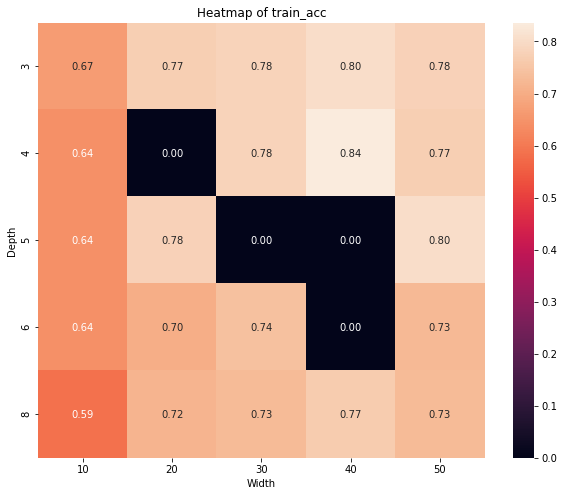

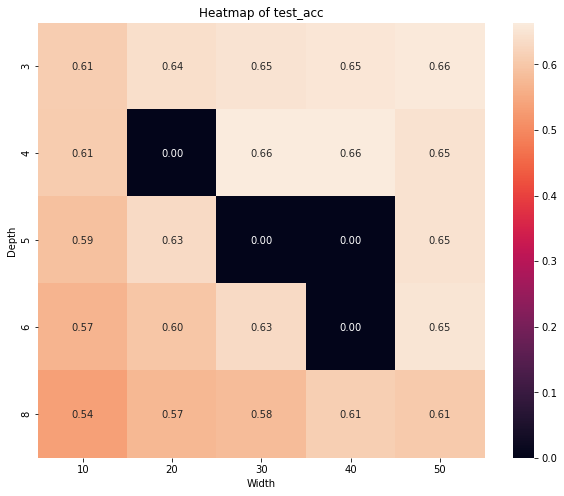

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random

# Assuming generate_cnn and Trainer classes are defined elsewhere

def random_search_hyperparams(depth_range, width_range, kernel_size_range, num_iterations, params, dataloader_wrapped, device):
    results = {}

    for _ in range(num_iterations):
        # Randomly select hyperparameters
        depth = random.choice(depth_range)
        width = random.choice(width_range)
        kernel_size = random.choice(kernel_size_range)

        # Update params
        params.update({'depth': depth, 'width': width, 'kernel_size': kernel_size})

        # Create and train the model
        model = generate_cnn(params, dataloader_wrapped.output_dim)
        model.to(device)
        trainer = Trainer(model, dataloader_wrapped, params["lr_pretrain"], params)
        train_acc, test_acc, _, _ = trainer.train()

        # Store results
        key = (depth, width, kernel_size)
        results[key] = {'train_acc': train_acc, 'test_acc': test_acc}

    return results

# Define hyperparameter ranges
depth_range = [3, 4, 5, 6, 8]
width_range = [10, 20, 30, 40, 50]
kernel_size_range = [3, 5, 7]

# Perform Random Search
num_iterations = 30 # Adjust as needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = random_search_hyperparams(depth_range, width_range, kernel_size_range, num_iterations, params, dataloader_wrapped, device)

# Plotting heatmaps
def plot_heatmaps(results):
    # Prepare data for heatmaps
    heatmap_data = {'train_acc': {}, 'test_acc': {}}
    for (depth, width, kernel_size), acc in results.items():
        heatmap_data['train_acc'][(depth, width)] = acc['train_acc']
        heatmap_data['test_acc'][(depth, width)] = acc['test_acc']

    for key, data in heatmap_data.items():
        # Convert data to 2D array
        array_data = np.zeros((len(depth_range), len(width_range)))
        for (depth, width), acc in data.items():
            i = depth_range.index(depth)
            j = width_range.index(width)
            array_data[i, j] = acc

        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(array_data, annot=True, fmt=".2f", xticklabels=width_range, yticklabels=depth_range)
        plt.title(f"Heatmap of {key}")
        plt.xlabel("Width")
        plt.ylabel("Depth")
        plt.show()

plot_heatmaps(results)


In [9]:
print(results)

{(5, 10, 7): {'train_acc': 0.6448888888888888, 'test_acc': 0.5896}, (6, 50, 5): {'train_acc': 0.7261111111111112, 'test_acc': 0.6522}, (4, 40, 7): {'train_acc': 0.8356666666666667, 'test_acc': 0.6618}, (8, 30, 7): {'train_acc': 0.7221777777777778, 'test_acc': 0.6121}, (3, 30, 3): {'train_acc': 0.7816222222222222, 'test_acc': 0.6498}, (8, 10, 5): {'train_acc': 0.6214888888888889, 'test_acc': 0.5675}, (3, 10, 7): {'train_acc': 0.6676, 'test_acc': 0.6103}, (3, 20, 5): {'train_acc': 0.7507111111111111, 'test_acc': 0.6509}, (3, 40, 5): {'train_acc': 0.8046222222222222, 'test_acc': 0.6546}, (8, 10, 7): {'train_acc': 0.5854666666666667, 'test_acc': 0.5354}, (6, 20, 3): {'train_acc': 0.7038444444444445, 'test_acc': 0.5971}, (4, 10, 7): {'train_acc': 0.644, 'test_acc': 0.6067}, (8, 20, 7): {'train_acc': 0.7177111111111111, 'test_acc': 0.575}, (5, 20, 7): {'train_acc': 0.7788222222222222, 'test_acc': 0.6343}, (4, 50, 7): {'train_acc': 0.8419111111111112, 'test_acc': 0.6459}, (6, 10, 5): {'train_

In [8]:
#Create DNN model
pretrained_model = generate_cnn(params, dataloader_wrapped.output_dim)
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (fc): Linear(in_features=65536, out_features=6, bias=True)
)

In [57]:
# Train and evaluate
trainer = Trainer(pretrained_model, dataloader_wrapped, params["lr_pretrain"], params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 45.41%
Validation Accuracy: 42.93%
Epoch: 1 	Training Accuracy: 55.43%
Validation Accuracy: 52.20%
Epoch: 2 	Training Accuracy: 63.03%
Validation Accuracy: 59.80%
Epoch: 3 	Training Accuracy: 67.44%
Validation Accuracy: 60.20%
Epoch: 4 	Training Accuracy: 74.81%
Validation Accuracy: 62.23%
Epoch: 5 	Training Accuracy: 80.25%
Validation Accuracy: 62.53%
Epoch: 6 	Training Accuracy: 85.19%
Validation Accuracy: 60.80%
Epoch: 7 	Training Accuracy: 92.27%
Validation Accuracy: 60.90%
Epoch: 8 	Training Accuracy: 94.98%
Validation Accuracy: 60.43%
Epoch: 9 	Training Accuracy: 95.16%
Validation Accuracy: 60.07%
Final Training Accuracy: 0.9516
Final Test Accuracy: 0.5908


In [58]:
# save model
torch.save(pretrained_model.state_dict(), 'modelcifar10.pth')

In [9]:
pretrained_model.load_state_dict(torch.load('modelcifar10.pth'))
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (fc): Linear(in_features=65536, out_features=6, bias=True)
)

In [10]:
eval(pretrained_model, device, dataloader_wrapped.test_loader, debug=True, classification_report_flag=True, is_cnn=True)


Average loss: 1.9859, Accuracy: 3545.0/6000 (59%)

              precision    recall  f1-score   support

     Class 0       0.52      0.58      0.55      1000
     Class 1       0.44      0.47      0.45      1000
     Class 2       0.63      0.54      0.58      1000
     Class 3       0.56      0.53      0.54      1000
     Class 4       0.75      0.70      0.73      1000
     Class 5       0.69      0.72      0.70      1000

    accuracy                           0.59      6000
   macro avg       0.60      0.59      0.59      6000
weighted avg       0.60      0.59      0.59      6000



0.5908333333333333

In [14]:
# save model for later use
torch.save(pretrained_model.state_dict(), 'pretrained_models/pretrained_0.001/pretrained_model_89percent.pth')

params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
#save params as well
with open('pretrained_models/pretrained_0.001/params.json', 'w') as fp:
    json.dump(params_tmp, fp)

## Fine-tuning Experiments

In [ ]:
# load results: to continue from a checkpoint (actually don't run)
with open('results.json', 'r') as f:
    results = json.load(f)

### Baselines (skip if it was already run)

In [61]:
results = []

In [62]:
#training of baseline, end to end, models (#trials x #percentages)

dataloader_wrapped.update_phase('finetune')

# template_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
#                      hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

for sampled_percentage in percentages:      
    if sampled_percentage <= 0.01:
        repeats = 5
    elif sampled_percentage < 0.5:
        repeats = 3
    else:
        repeats = 1
    
    for repeat in range(repeats):
        # Print or log the sampled values for transparency
        print(f"\nSampled Percentage: {sampled_percentage}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

        # Reduce the dataset
        train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
        torch.manual_seed(repeat)
        #train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

        # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
        params_tmp = copy.deepcopy(params)
        params_tmp["reinit"] = True
        model_new = cut_custom_cnn_model(pretrained_model, cut_point=0, params=params_tmp, output_dim=dataloader_wrapped.output_dim)
        model_new.to(device)

        # Train and evaluate
        trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
        train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
        print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

        # Store the results
        results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":-1, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc}) # -1 for the cut point means it's baseline


Sampled Percentage: 0.001, Lr: 0.001, Repeat: 0
Early stopping invoked.


In [42]:
results_baseline = results

In [21]:
# save baseline results
params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results

with open(f'results_jsons/baselines_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_dummy_run.json', 'w') as f:
    json.dump(results, f)

In [22]:
#load results
with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_dummy_run.json', 'r') as f:
    results_baseline = json.load(f)

# keep only the ones with cut_point = -1
results_baseline = results_baseline[1:]
results_baseline = [result for result in results_baseline if result["sampled_cut_point"] == -1]

### Fine-tuning

In [13]:
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1]
 #percentages = [0.001, 0.002]
results = []

In [14]:
dataloader_wrapped.update_phase('finetune')

# Store results
#results = []
# Store unique combinations that have been tested: we need this if we want to test random combinations
# tested_combinations = set()

# for lr in learning_rates:
#     params["lr"] = lr
# repeating the whole thing with multiple lr and saving the results somewhere
for sampled_percentage in percentages:

    if sampled_percentage <= 0.01:
        repeats = 25
    elif sampled_percentage < 0.5:
        repeats = 20
    else:
        repeats = 15
        
    for sampled_cut_point in cuts:

        for repeat in range(repeats):
            # Add the combination to the tested set
            # tested_combinations.add((sampled_percentage, sampled_cut_point))

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=repeat)
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)
            torch.manual_seed(repeat) # because in the cut function we reinitialize some layers too (at least the dense layers)
            
            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, params=params, output_dim=dataloader_wrapped.output_dim)
            model_new.to(device)
            
            # Train and evaluate
            trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":sampled_cut_point, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc})


Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.8750, Test Accuracy: 0.4273

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.001, Repeat: 1
Training Accuracy: 0.9375, Test Accuracy: 0.3935

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.001, Repeat: 2
Training Accuracy: 1.0000, Test Accuracy: 0.3633

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.8750, Test Accuracy: 0.3070

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.6250, Test Accuracy: 0.2898

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.001, Repeat: 5
Training Accuracy: 0.8750, Test Accuracy: 0.3625

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.001, Repeat: 6
Training Accuracy: 1.0000, Test Accuracy: 0.3860

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.001, Repeat: 7
Early stopping in

In [16]:
print(results)

[{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.875, 'test_acc': 0.42725}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9375, 'test_acc': 0.3935}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.36325}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.875, 'test_acc': 0.307}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.625, 'test_acc': 0.28975}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.875, 'test_acc': 0.3625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.386}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.9375, 'test_acc': 0.41125}, {'lr': 0.001, 'sampled_percenta

In [27]:
# save fine-tuning results
params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results

with open(f'results_jsons/results_freeze_{params["freeze"]}_reinit_{params["reinit"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_dummy_run.json', 'w') as f:
    json.dump(results, f)
results = results[1:]

# Visualizations

In [17]:
results_baseline = [{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.875, 'test_acc': 0.42725}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9375, 'test_acc': 0.3935}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.36325}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.875, 'test_acc': 0.307}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.625, 'test_acc': 0.28975}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.875, 'test_acc': 0.3625}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.386}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.9375, 'test_acc': 0.41125}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.6875, 'test_acc': 0.38675}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.32225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.36225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.8125, 'test_acc': 0.4005}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.75, 'test_acc': 0.3765}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.8125, 'test_acc': 0.275}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.875, 'test_acc': 0.40725}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.9375, 'test_acc': 0.337}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.5, 'test_acc': 0.337}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.9375, 'test_acc': 0.3925}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.5625, 'test_acc': 0.35175}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.875, 'test_acc': 0.36225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 20, 'train_acc': 0.9375, 'test_acc': 0.3785}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.4}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 22, 'train_acc': 0.8125, 'test_acc': 0.40675}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 23, 'train_acc': 0.9375, 'test_acc': 0.2735}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 24, 'train_acc': 0.6875, 'test_acc': 0.42325}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.6944444444444444, 'test_acc': 0.413}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.7222222222222222, 'test_acc': 0.39225}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.6666666666666666, 'test_acc': 0.436}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.8888888888888888, 'test_acc': 0.30875}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.75, 'test_acc': 0.35025}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.7777777777777778, 'test_acc': 0.43675}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.8888888888888888, 'test_acc': 0.4135}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.75, 'test_acc': 0.4175}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.8888888888888888, 'test_acc': 0.38775}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.8611111111111112, 'test_acc': 0.4145}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.8611111111111112, 'test_acc': 0.39425}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.8611111111111112, 'test_acc': 0.38325}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.6111111111111112, 'test_acc': 0.42375}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.6666666666666666, 'test_acc': 0.33675}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.8333333333333334, 'test_acc': 0.404}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.75, 'test_acc': 0.33025}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.8055555555555556, 'test_acc': 0.305}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.7222222222222222, 'test_acc': 0.36625}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.5833333333333334, 'test_acc': 0.33425}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.9166666666666666, 'test_acc': 0.385}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 20, 'train_acc': 0.8888888888888888, 'test_acc': 0.345}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 21, 'train_acc': 0.7777777777777778, 'test_acc': 0.42575}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 22, 'train_acc': 0.8333333333333334, 'test_acc': 0.33575}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 23, 'train_acc': 0.3888888888888889, 'test_acc': 0.29825}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': -1, 'repeat': 24, 'train_acc': 0.8333333333333334, 'test_acc': 0.387}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.6590909090909091, 'test_acc': 0.43125}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.6022727272727273, 'test_acc': 0.3375}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.6590909090909091, 'test_acc': 0.416}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.5568181818181818, 'test_acc': 0.39725}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.5454545454545454, 'test_acc': 0.40325}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.5795454545454546, 'test_acc': 0.39775}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.3409090909090909, 'test_acc': 0.31675}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.625, 'test_acc': 0.38625}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.7727272727272727, 'test_acc': 0.413}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.6363636363636364, 'test_acc': 0.41725}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.5227272727272727, 'test_acc': 0.39575}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.625, 'test_acc': 0.42725}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.75, 'test_acc': 0.40975}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.5909090909090909, 'test_acc': 0.4145}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.6931818181818182, 'test_acc': 0.44825}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.75, 'test_acc': 0.40125}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.5909090909090909, 'test_acc': 0.375}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.45454545454545453, 'test_acc': 0.3425}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.5795454545454546, 'test_acc': 0.4815}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.6704545454545454, 'test_acc': 0.382}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 20, 'train_acc': 0.6477272727272727, 'test_acc': 0.3645}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 21, 'train_acc': 0.6363636363636364, 'test_acc': 0.4485}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 22, 'train_acc': 0.25, 'test_acc': 0.25}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 23, 'train_acc': 0.5113636363636364, 'test_acc': 0.34925}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': -1, 'repeat': 24, 'train_acc': 0.625, 'test_acc': 0.43025}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.6388888888888888, 'test_acc': 0.44775}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.5555555555555556, 'test_acc': 0.472}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.5833333333333334, 'test_acc': 0.44025}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.6944444444444444, 'test_acc': 0.44675}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.5666666666666667, 'test_acc': 0.4635}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.5444444444444444, 'test_acc': 0.43275}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.7, 'test_acc': 0.4545}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.5666666666666667, 'test_acc': 0.48425}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.6055555555555555, 'test_acc': 0.43725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.6111111111111112, 'test_acc': 0.4515}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.5888888888888889, 'test_acc': 0.43525}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.6166666666666667, 'test_acc': 0.417}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.5944444444444444, 'test_acc': 0.42725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.6277777777777778, 'test_acc': 0.50725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.5333333333333333, 'test_acc': 0.439}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.6277777777777778, 'test_acc': 0.42525}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.55, 'test_acc': 0.4505}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.5111111111111111, 'test_acc': 0.39925}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.6444444444444445, 'test_acc': 0.465}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.6277777777777778, 'test_acc': 0.44375}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 20, 'train_acc': 0.5111111111111111, 'test_acc': 0.4305}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 21, 'train_acc': 0.6111111111111112, 'test_acc': 0.4725}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 22, 'train_acc': 0.5722222222222222, 'test_acc': 0.46975}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 23, 'train_acc': 0.6888888888888889, 'test_acc': 0.4985}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': -1, 'repeat': 24, 'train_acc': 0.6, 'test_acc': 0.417}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.6222222222222222, 'test_acc': 0.541}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.69, 'test_acc': 0.551}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.6944444444444444, 'test_acc': 0.535}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.6344444444444445, 'test_acc': 0.55875}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.6444444444444445, 'test_acc': 0.55125}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.6633333333333333, 'test_acc': 0.5475}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.5322222222222223, 'test_acc': 0.50225}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.6955555555555556, 'test_acc': 0.5505}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.7411111111111112, 'test_acc': 0.537}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.7711111111111111, 'test_acc': 0.55925}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.69, 'test_acc': 0.522}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.5633333333333334, 'test_acc': 0.5195}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.6933333333333334, 'test_acc': 0.56375}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.7322222222222222, 'test_acc': 0.58625}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.6055555555555555, 'test_acc': 0.5285}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.65, 'test_acc': 0.569}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.6322222222222222, 'test_acc': 0.55825}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.6455555555555555, 'test_acc': 0.56375}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.6744444444444444, 'test_acc': 0.55225}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.8788888888888889, 'test_acc': 0.5275}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.8116666666666666, 'test_acc': 0.639}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9466666666666667, 'test_acc': 0.58475}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.8122222222222222, 'test_acc': 0.591}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.7255555555555555, 'test_acc': 0.59075}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.8122222222222222, 'test_acc': 0.59925}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.8988888888888888, 'test_acc': 0.652}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.8166666666666667, 'test_acc': 0.6125}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.875, 'test_acc': 0.6295}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.795, 'test_acc': 0.61625}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.9266666666666666, 'test_acc': 0.6165}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.7511111111111111, 'test_acc': 0.62}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.83, 'test_acc': 0.62875}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.745, 'test_acc': 0.62575}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.9205555555555556, 'test_acc': 0.6405}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.8688888888888889, 'test_acc': 0.59775}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.7988888888888889, 'test_acc': 0.5955}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.7316666666666667, 'test_acc': 0.60975}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.8066666666666666, 'test_acc': 0.62725}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.925, 'test_acc': 0.59475}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.8177777777777778, 'test_acc': 0.6305}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9535185185185185, 'test_acc': 0.766}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9679629629629629, 'test_acc': 0.746}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9568518518518518, 'test_acc': 0.72275}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.9387037037037037, 'test_acc': 0.74525}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9433333333333334, 'test_acc': 0.759}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.9742592592592593, 'test_acc': 0.701}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.9868518518518519, 'test_acc': 0.72125}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 0.9338888888888889, 'test_acc': 0.736}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 8, 'train_acc': 0.8357407407407408, 'test_acc': 0.743}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 9, 'train_acc': 0.9366666666666666, 'test_acc': 0.757}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 10, 'train_acc': 0.9207407407407407, 'test_acc': 0.7585}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 11, 'train_acc': 0.98, 'test_acc': 0.7365}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 12, 'train_acc': 0.9775925925925926, 'test_acc': 0.7365}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 13, 'train_acc': 0.9753703703703703, 'test_acc': 0.72825}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 14, 'train_acc': 0.8312962962962963, 'test_acc': 0.72875}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 15, 'train_acc': 0.9851851851851852, 'test_acc': 0.74025}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 16, 'train_acc': 0.9594444444444444, 'test_acc': 0.74725}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 17, 'train_acc': 0.8927777777777778, 'test_acc': 0.7075}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 18, 'train_acc': 0.9166666666666666, 'test_acc': 0.7275}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': -1, 'repeat': 19, 'train_acc': 0.9605555555555556, 'test_acc': 0.7225}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9165555555555556, 'test_acc': 0.78425}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9495555555555556, 'test_acc': 0.75}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9834444444444445, 'test_acc': 0.797}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.9605555555555556, 'test_acc': 0.7885}, {'lr': 0.001, 'sampled_percentage': 0.5, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9641111111111111, 'test_acc': 0.7535}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9686111111111111, 'test_acc': 0.83175}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.9715972222222222, 'test_acc': 0.82475}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.888125, 'test_acc': 0.82675}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.9238888888888889, 'test_acc': 0.81525}, {'lr': 0.001, 'sampled_percentage': 0.8, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9759027777777778, 'test_acc': 0.823}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.9804522165292938, 'test_acc': 0.82225}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.982290042325685, 'test_acc': 0.82425}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.9820672755624861, 'test_acc': 0.83575}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.9751615059033192, 'test_acc': 0.83275}, {'lr': 0.001, 'sampled_percentage': 1, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.9160726219648029, 'test_acc': 0.83925}]

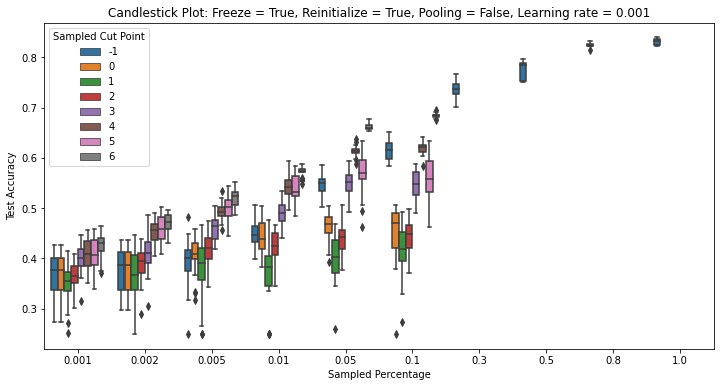

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combining both datasets for comparative analysis
# df_combined = pd.DataFrame(results)
df_combined = pd.DataFrame(results_baseline+results)

# Creating boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='sampled_percentage', y='test_acc', hue='sampled_cut_point', data=df_combined)
plt.title(f'Candlestick Plot: Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.xlabel('Sampled Percentage')
plt.ylabel('Test Accuracy')
plt.legend(title='Sampled Cut Point')
plt.show()

In [ ]:
#save results
with open(f'results_jsons/results_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_dummy_run_MNIST.json', 'w') as f:
    json.dump(results, f)

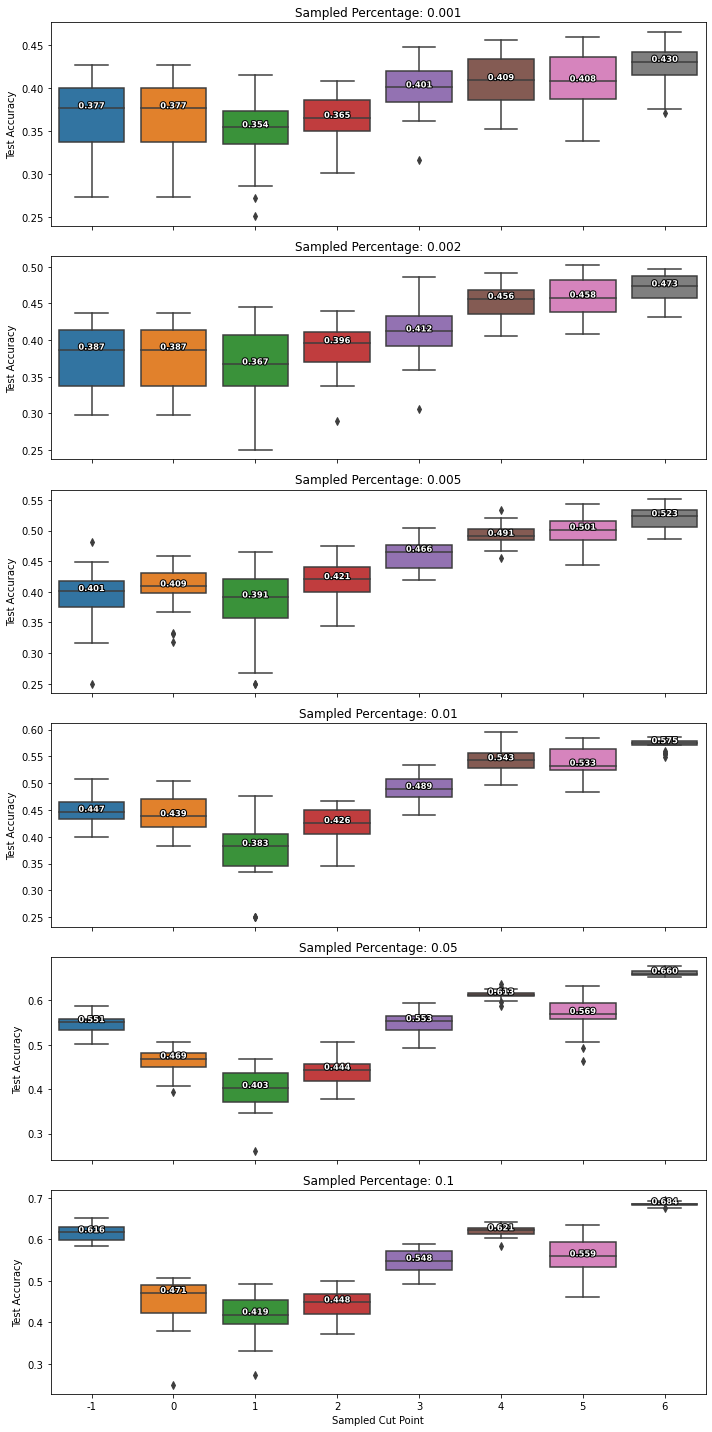

In [19]:
from matplotlib import patheffects

# Creating subplots for each data percentage



unique_percentages = df_combined['sampled_percentage'].unique()
#only 0.001 and 0.002
unique_percentages = percentages

n_percentages = len(unique_percentages)

# Adjusting the subplot layout for better readability of median values (improving contrast)
fig, axes = plt.subplots(nrows=n_percentages, ncols=1, figsize=(10, 20), sharex=True)

for i, percentage in enumerate(sorted(unique_percentages)):
    # Filtering data for each percentage
    df_subset = df_combined[df_combined['sampled_percentage'] == percentage]
    
    # Creating a boxplot for the current percentage
    sns.boxplot(x='sampled_cut_point', y='test_acc', data=df_subset, ax=axes[i])
    axes[i].set_title(f'Sampled Percentage: {percentage}')
    axes[i].set_xlabel('Sampled Cut Point')
    if i == n_percentages - 1:
        axes[i].set_xlabel('Sampled Cut Point')
    else:
        axes[i].set_xlabel('')
    axes[i].set_ylabel('Test Accuracy')

    # Annotating each boxplot with the median value and adjusting for better contrast
    medians = df_subset.groupby(['sampled_cut_point'])['test_acc'].median().sort_index()
    for j, median in enumerate(medians):
        text = axes[i].text(j, median, f'{median:.3f}', 
                            horizontalalignment='center', size='small', color='white', weight='semibold')
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground="black")])

plt.tight_layout()
plt.show()


In [41]:
#print results for cut point = -1
results_baseline[:15]


[{'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 0,
  'train_acc': 1.0,
  'test_acc': 0.7899609133923061},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 1,
  'train_acc': 0.2,
  'test_acc': 0.20757045875334293},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 2,
  'train_acc': 1.0,
  'test_acc': 0.7656860728245217},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 3,
  'train_acc': 1.0,
  'test_acc': 0.7556058424192553},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 4,
  'train_acc': 1.0,
  'test_acc': 0.7368854145237606},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 5,
  'train_acc': 1.0,
  'test_acc': 0.7045875334293356},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': -1,
  'repeat': 6,
  'train_acc': 1.0,
  'test_acc': 0.5918535280806418}

In [42]:
#results where cut point = 0
results_cut_0 = [result for result in results if result["sampled_cut_point"] == 0]
results_cut_0[:15]

[{'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 0,
  'train_acc': 1.0,
  'test_acc': 0.8043612425426867},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 1,
  'train_acc': 1.0,
  'test_acc': 0.7761777412055133},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 2,
  'train_acc': 0.96,
  'test_acc': 0.8372762806006995},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 3,
  'train_acc': 1.0,
  'test_acc': 0.7642460399094837},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 4,
  'train_acc': 1.0,
  'test_acc': 0.7486113968319276},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 5,
  'train_acc': 1.0,
  'test_acc': 0.7574573133100185},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 6,
  'train_acc': 1.0,
  'test_acc': 0.6418432421312487},
 {'lr

In [46]:
# Print or log the sampled values for transparency
sampled_percentage = 0.001
sampled_cut_point = 0
repeat = 0

print(f"\nSampled Percentage: {sampled_percentage}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

# Reduce the dataset
train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
torch.manual_seed(repeat)
#train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

# Copy and then cut the model - we already deepcopy it in the function: pretrained_model
#model_temp = copy.deepcopy(template_model)
model_temp = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

model_temp.to(device)

# Train and evaluate
trainer = Trainer(model_temp, dataset_namespace_new, params['lr_fine_tune'], params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# Store the results
print({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":-1, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc}) # -1 for the cut point means it's baseline


Sampled Percentage: 0.001, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7900
{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.7899609133923061}


In [71]:
torch.manual_seed(repeat)

model_temp = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

model_temp.to(device)


print(model_temp.conv0.weight[0][0][0])


tensor([-0.0015,  0.1073, -0.1646, -0.1472, -0.0770],
       grad_fn=<SelectBackward0>)


In [73]:
torch.manual_seed(2)


model_new = cut_custom_cnn_model(model_temp, cut_point=sampled_cut_point, params=params)

print(model_new.conv0.weight[0][0][0])


tensor([ 0.0459, -0.0476,  0.0548, -0.0102,  0.0854],
       grad_fn=<SelectBackward0>)


In [47]:
# Add the combination to the tested set
# tested_combinations.add((sampled_percentage, sampled_cut_point))

# Print or log the sampled values for transparency
print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

# Reduce the dataset
train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=repeat)
dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)
torch.manual_seed(repeat) # because in the cut function we reinitialize some layers too (at least the dense layers)

# Copy and then cut the model - we already deepcopy it in the function: pretrained_model
model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, params=params)

# Train and evaluate
trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# Store the results
print({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":sampled_cut_point, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc})


Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.8044
{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8043612425426867}


In [34]:
median_baseline = df_combined[df_combined['sampled_cut_point'] == -1].groupby('sampled_percentage')['test_acc'].median()
df_with_baseline = df_combined.merge(median_baseline, on='sampled_percentage', suffixes=('', '_baseline'))
df_with_baseline['diff_to_baseline'] = df_with_baseline['test_acc'] - df_with_baseline['test_acc_baseline']
df_differences = df_with_baseline[df_with_baseline['sampled_cut_point'] != -1]

from scipy.stats import wilcoxon
import numpy as np

def perform_wilcoxon_test(data, baseline_median, cut_point):
    cut_data = data[data['sampled_cut_point'] == cut_point]['test_acc']
    baseline_data = np.full(len(cut_data), baseline_median)  # Creating an array of baseline values

    # Performing the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(cut_data, baseline_data)
    return stat, p_value

# Performing the test for each cut point and sampled percentage
wilcoxon_corrected_results = []
for percentage in df_differences['sampled_percentage'].unique():
    baseline_median = median_baseline[percentage]
    for cut_point in df_differences[df_differences['sampled_cut_point'] != -1]['sampled_cut_point'].unique():
        subset = df_differences[(df_differences['sampled_percentage'] == percentage) & (df_differences['sampled_cut_point'] == cut_point)]
        stat, p_value = perform_wilcoxon_test(subset, baseline_median, cut_point)
        wilcoxon_corrected_results.append({
            'sampled_percentage': percentage,
            'sampled_cut_point': cut_point,
            'statistic': stat,
            'p_value': p_value
        })

# Converting the results to a DataFrame for easier visualization
df_wilcoxon_corrected = pd.DataFrame(wilcoxon_corrected_results)


In [35]:
# add a columns saying if the p-value is significant or not
df_wilcoxon_corrected['is_significant'] = df_wilcoxon_corrected['p_value'] < 0.05
df_wilcoxon_corrected

,sampled_percentage,sampled_cut_point,statistic,p_value,is_significant
0,0.001,0,89.0,0.570597,False
1,0.001,1,101.0,0.898317,False
2,0.001,2,28.0,0.002712,True
3,0.001,3,21.0,0.000851,True
4,0.002,0,86.0,0.498009,False
5,0.002,1,85.0,0.474905,False
6,0.002,2,23.0,0.001209,True
7,0.002,3,37.0,0.009436,True
